In [16]:
import sys
if "../" not in sys.path: sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm

import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams["figure.facecolor"] = "white"
sns.set_style("white")
# sns.set_style("ticks")
from mpl_toolkits.axes_grid.inset_locator import inset_axes

%matplotlib inline
%load_ext autoreload
%autoreload 2

from analysis_helpers import *

from eye_tracking.eye_tracking import get_stim_at_frame, get_saccade_magnitude_direction
from experiment.cre_line import match_cre_line
from eye_plotting import STIM_ABBREV, STIM_COLORS

from saccade_config import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
boc = BrainObservatoryCache(manifest_file=BRAIN_OBSERVATORY_CACHE_MANIFEST_FILE)

In [18]:
cell_metrics = pd.DataFrame(boc.get_cell_specimens())
cell_metrics.head()

,all_stim,area,cell_specimen_id,donor_full_genotype,dsi_dg,experiment_container_id,failed_experiment_container,g_dsi_dg,g_osi_dg,g_osi_sg,...,specimen_id,tfdi_dg,time_to_peak_ns,time_to_peak_sg,tld1_id,tld1_name,tld2_id,tld2_name,tlr1_id,tlr1_name
0,False,VISp,517397327,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,NaN,511498742,False,NaN,NaN,NaN,...,502185555,NaN,NaN,NaN,177837516,Scnn1a-Tg3-Cre,177837320.0,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
1,False,VISp,517397340,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,1.461268,511498742,False,0.824858,0.901542,NaN,...,502185555,0.333074,NaN,NaN,177837516,Scnn1a-Tg3-Cre,177837320.0,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
2,False,VISp,517397343,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,NaN,511498742,False,0.812462,0.894923,NaN,...,502185555,0.258131,NaN,NaN,177837516,Scnn1a-Tg3-Cre,177837320.0,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
3,False,VISp,517397347,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,NaN,511498742,False,0.078742,0.109241,NaN,...,502185555,0.231590,NaN,NaN,177837516,Scnn1a-Tg3-Cre,177837320.0,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)
4,False,VISp,517397353,Scnn1a-Tg3-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaM...,NaN,511498742,False,NaN,NaN,NaN,...,502185555,NaN,NaN,NaN,177837516,Scnn1a-Tg3-Cre,177837320.0,Camk2a-tTA,265943423,Ai93(TITL-GCaMP6f)


In [19]:
cell_metrics.columns

Index(['all_stim', 'area', 'cell_specimen_id', 'donor_full_genotype', 'dsi_dg',
       'experiment_container_id', 'failed_experiment_container', 'g_dsi_dg',
       'g_osi_dg', 'g_osi_sg', 'image_sel_ns', 'imaging_depth', 'osi_dg',
       'osi_sg', 'p_dg', 'p_ns', 'p_run_mod_dg', 'p_run_mod_ns',
       'p_run_mod_sg', 'p_sg', 'peak_dff_dg', 'peak_dff_ns', 'peak_dff_sg',
       'pref_dir_dg', 'pref_image_ns', 'pref_ori_sg', 'pref_phase_sg',
       'pref_sf_sg', 'pref_tf_dg', 'reliability_dg', 'reliability_nm1_a',
       'reliability_nm1_b', 'reliability_nm1_c', 'reliability_nm2',
       'reliability_nm3', 'reliability_ns', 'reliability_sg',
       'rf_area_off_lsn', 'rf_area_on_lsn', 'rf_center_off_x_lsn',
       'rf_center_off_y_lsn', 'rf_center_on_x_lsn', 'rf_center_on_y_lsn',
       'rf_chi2_lsn', 'rf_distance_lsn', 'rf_overlap_index_lsn', 'run_mod_dg',
       'run_mod_ns', 'run_mod_sg', 'sfdi_sg', 'specimen_id', 'tfdi_dg',
       'time_to_peak_ns', 'time_to_peak_sg', 'tld1_id', 'tld1

In [20]:
IS_SPONTANEOUS = False
SAVE_FOLDER_PREFIX = "spontaneous/" if IS_SPONTANEOUS else ""
CRE_PLOT_KEY = "cre_abbrev"

cells = load_additional_data(LOADED_CLASSIFIED_CELLS_SPONTANEOUS_CSV if IS_SPONTANEOUS else LOADED_CLASSIFIED_CELLS_CSV, in_data_dir=False, index_col=0)
add_cell_df_columns(cells)
print(f"There are {len(cells):,} total cells.")
cells.head()

There are 32,504 total cells.


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_total,n_left,...,depth_trunc,cortical_layer,is_sr,is_sr_ds,is_sr_miura,is_sr_ds_miura,preferred_direction,preferred_direction_miura,sr_label,sr_label_miura
specimen_id,,,,,,,,,,,,,,,,,,,,,
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 11), (510345479, 67), (510514474,...",0,0.161850,70,25,...,100,2/3,False,False,False,False,0,NaN,No response,No response
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 109), (510345479, 68), (510514474...",0,0.879275,70,25,...,100,2/3,False,False,False,False,0,NaN,No response,No response
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 27), (510345479, 205), (510514474...",0,0.995625,70,25,...,100,2/3,False,False,True,True,0,NaN,No response,No response
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 6), (510345479, 206), (510514474,...",0,0.019375,70,25,...,100,2/3,False,False,False,False,0,NaN,No response,No response
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175,VISp,511510718,"((510174759, 9), (510345479, 22), (510514474, 9))",0,0.273825,70,25,...,100,2/3,False,False,False,False,0,NaN,No response,No response


In [21]:
cell_ids_not_sr = cells.index[cells.response_classification == 0]
cell_ids_sr = cells.index[cells.response_classification != 0]
cell_ids_sr_nasal = cells.index[(cells.response_classification == 1) & (cells.ranksum_p_by_direction < 0.05) & (cells.mean_left_response > cells.mean_right_response)]
cell_ids_sr_temporal = cells.index[(cells.response_classification == 1) & (cells.ranksum_p_by_direction < 0.05) & (cells.mean_left_response < cells.mean_right_response)]
cell_ids_sr_not_ds = cells.index[(cells.response_classification == 1) & (cells.ranksum_p_by_direction >= 0.05)]
cell_ids_sr_suppressed = cells.index[(cells.response_classification == -1)]
print(len(cell_ids_sr_nasal), len(cell_ids_sr_temporal), len(cell_ids_sr_not_ds), len(cell_ids_sr_suppressed), len(cell_ids_not_sr))

310 1474 916 368 29436


In [22]:
print("N enhanced:", (cells.response_classification == 1).sum())

N enhanced: 2700


In [23]:
VISUAL_AREAS = (
    (["VISp"], "V1"),
    (['VISal', 'VISl', 'VISpm', 'VISam', 'VISrl'], "HVAs")
)

# Print out the fraction with receptive fields

In [24]:
is_sr_mask = cell_metrics.cell_specimen_id.isin(cell_ids_sr)
has_on_mask = ~cell_metrics.rf_center_on_x_lsn.isna()
has_off_mask = ~cell_metrics.rf_center_off_x_lsn.isna()

for areas, area_name in VISUAL_AREAS:
    area_mask = cell_metrics.area.isin(areas)
    on_mask = is_sr_mask & area_mask & has_on_mask
    off_mask = is_sr_mask & area_mask & has_off_mask
    n_on = np.count_nonzero(on_mask)
    n_off = np.count_nonzero(off_mask)
    n_on_or_off = np.count_nonzero(on_mask | off_mask)
    print(f"{area_name} n_any={n_on_or_off}, n_on={n_on}, n_off={n_off} (total SR = {np.count_nonzero(is_sr_mask & area_mask)})")

V1 n_any=341, n_on=209, n_off=170 (total SR = 1050)
HVAs n_any=381, n_on=174, n_off=254 (total SR = 2018)


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


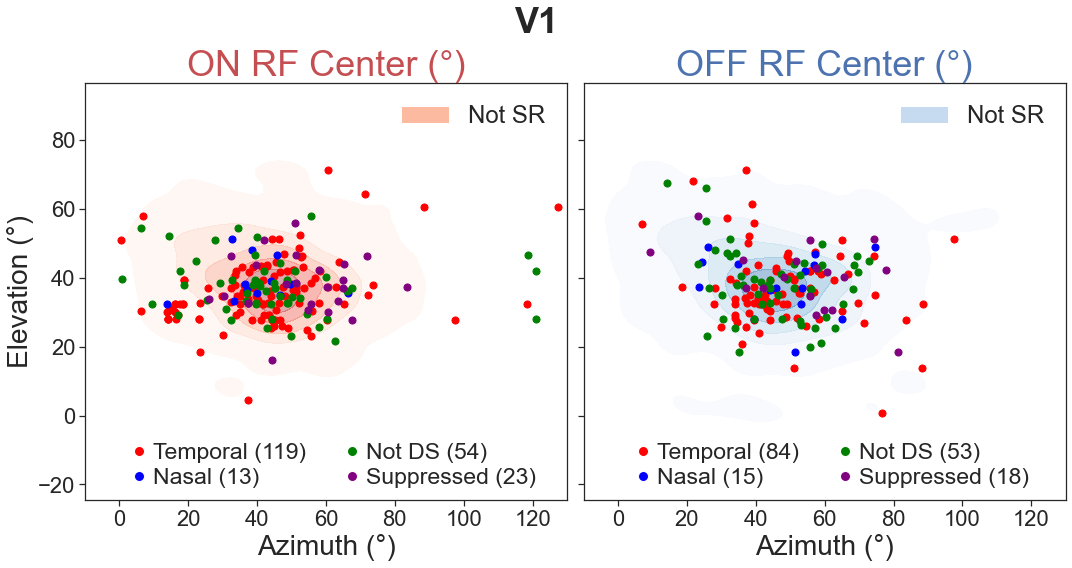

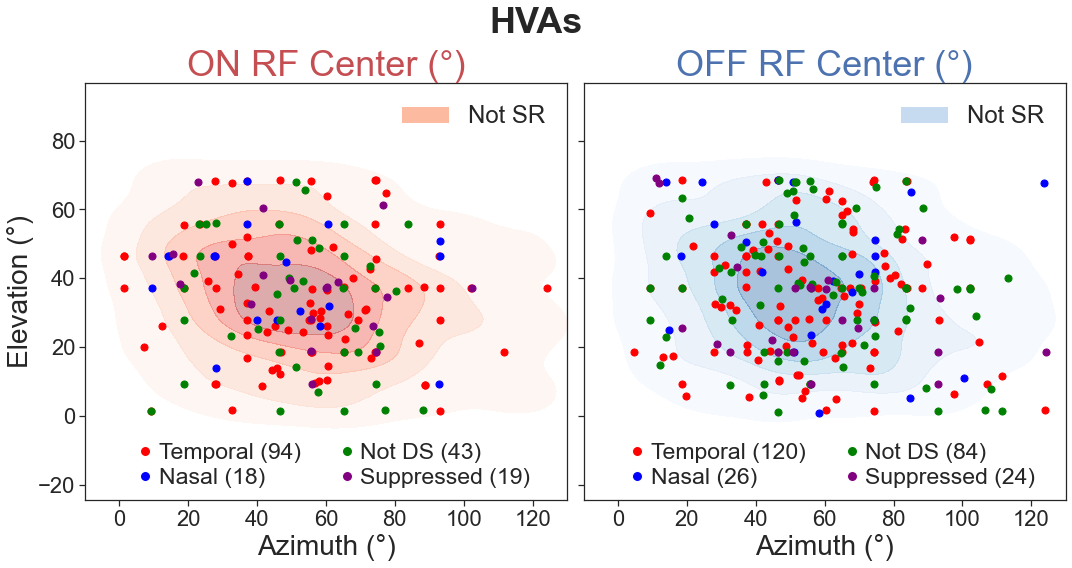

In [25]:
ids_and_labels_sr_not_sr = (
    (cell_ids_not_sr, "Not SR"),
    (cell_ids_sr, "SR")
)

# if IS_SPONTANEOUS:
#     ids_and_labels_sr_breakdown = (
#         (cell_ids_not_sr, "Not SR"),
#         # (cell_ids_sr_nasal, "Nasal"),
#         (cell_ids_sr_temporal, "Temporal"),
#         (cell_ids_sr_not_ds, "Not DS"),
#         (cell_ids_sr_suppressed, "Suppressed")
#     )
ids_and_labels_sr_breakdown = (
    (cell_ids_not_sr, "Not SR"),
    (cell_ids_sr_nasal, "Nasal"),
    (cell_ids_sr_temporal, "Temporal"),
    (cell_ids_sr_not_ds, "Not DS"),
    (cell_ids_sr_suppressed, "Suppressed")
)

cmap_on = plt.cm.Reds
cmap_off = plt.cm.Blues

with sns.axes_style("ticks"):
    for areas, area_name in VISUAL_AREAS:
        fig, axs = plt.subplots(figsize=(15, 8), ncols=2, sharex=True)

        for col, rf_type in enumerate(("on", "off")):
            ax = axs[col]
            met = cell_metrics[(cell_metrics.area.isin(areas)) & ~cell_metrics[f"rf_center_{rf_type}_x_lsn"].isna()]
            s = 50


            for cell_ids, sr_label in ids_and_labels_sr_not_sr:
                if sr_label == "SR":
                    handles = []

                    for ids, name, color in (
                        (cell_ids_sr_temporal, "Temporal", "red"),
                        (cell_ids_sr_nasal, "Nasal", "blue"),
                        (cell_ids_sr_not_ds, "Not DS", "green"),
                        (cell_ids_sr_suppressed, "Suppressed", "purple"),
                    ):
                        met2 = met[met.cell_specimen_id.isin(ids)]

                        if len(met2) > 0:
                            rf_x = met2[f"rf_center_{rf_type}_x_lsn"]
                            rf_y = met2[f"rf_center_{rf_type}_y_lsn"]
                            ax.scatter(rf_x, rf_y, color=color, s=s, alpha=1, label=f"{name}")
                            handles.append(mpl.lines.Line2D([0], [0], marker='o', color="white", label=f"{name} ({len(met2)})", markerfacecolor=color, markersize=10))
                            # handles.append(mpl.lines.Line2D([0], [0], marker='o', color="white", label=f"{len(met2)}", markerfacecolor=color, markersize=10))
                    
                    # Legend showing number points
                    labels = [p.get_label() for p in handles]
                    ax.add_artist(mpl.legend.Legend(ax, handles=handles, labels=labels, loc="lower center", bbox_to_anchor=(0.5, -0.02), ncol=2, fontsize=23, frameon=False, labelspacing=0.2, columnspacing=1, handletextpad=-0.4))

                    # if col == 1:
                        # Legend off right of plot showing colors
                        # ax.legend(loc="upper left", fontsize=20, bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
                else:
                    met2 = met[cell_metrics.cell_specimen_id.isin(cell_ids)]
                    rf_x = met2[f"rf_center_{rf_type}_x_lsn"]
                    rf_y = met2[f"rf_center_{rf_type}_y_lsn"]

                    # ax.scatter(rf_x, rf_y, color="black", alpha=0.25, zorder=10)
                    cmap = cmap_on if rf_type == "on" else cmap_off
                    sns.kdeplot(x=rf_x, y=rf_y, fill=True, levels=6, cmap=cmap, ax=ax, alpha=0.35)

                    # Add legend
                    handles = [
                        mpl.patches.Patch(facecolor=cmap(0.25), label=f"Not SR")
                    ]
                    labels = [p.get_label() for p in handles]
                    ax.add_artist(mpl.legend.Legend(ax, handles=handles, labels=labels, loc="upper right", frameon=False, fontsize=24))
            
            ax.set_title(f"{rf_type.upper()} RF Center (°)", color=("r" if rf_type == "on" else "b"), fontsize=36)
            ax.axis("equal")
            ax.set_xlim(-10, 130)
            ax.tick_params(labelsize=22)
            ax.set_xlabel("Azimuth (°)", fontsize=28)
            if col == 0:
                ax.set_ylabel("Elevation (°)", fontsize=28)
            else:
                ax.set_ylabel("")
                ax.set_ylim(axs[0].get_ylim())
                ax.set_yticklabels([])
            

        fig.suptitle(f"{area_name}", fontsize=36, fontweight="bold")
        fig.tight_layout()
        savefig(fig, f"{SAVE_FOLDER_PREFIX}rf_locations_{area_name}.png")

V1 0 4 0.010011445356858136
V1 1 4 0.00608973637136315
V1 2 4 0.0020474726011301754
V1 0 2 0.007820454043430966


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


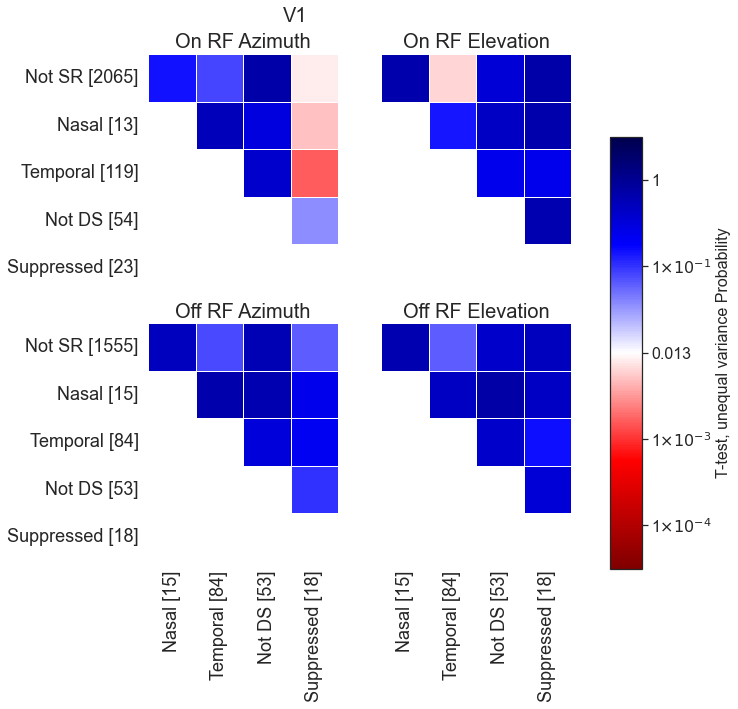

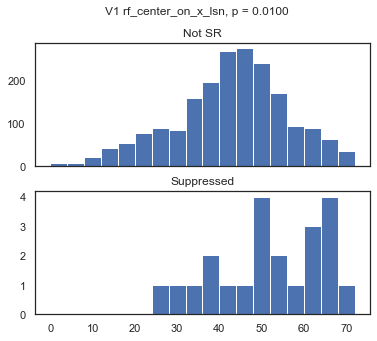

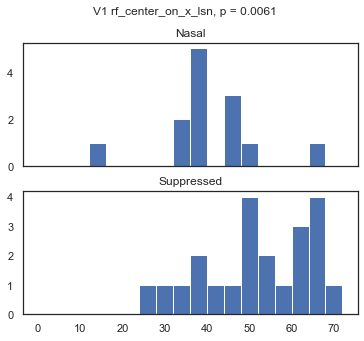

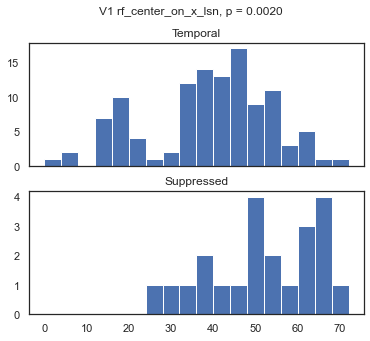

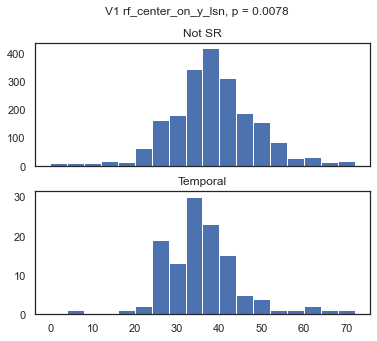

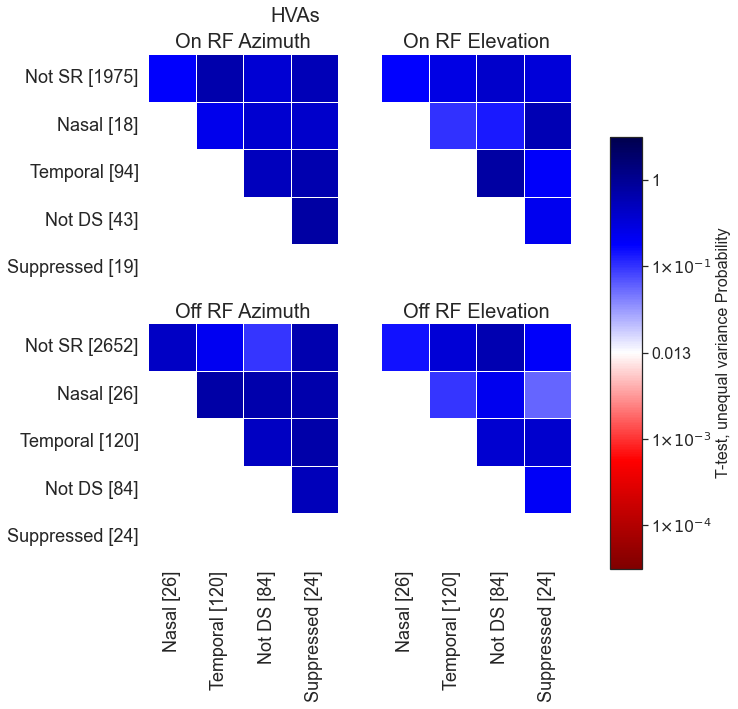

In [26]:
# proba_test, proba_test_name = scipy.stats.ks_2samp, "KS Test"
# proba_test, proba_test_name = scipy.stats.ttest_ind, "T-test, equal variance"
proba_test, proba_test_name = lambda a, b: scipy.stats.ttest_ind(a, b, equal_var=False), "T-test, unequal variance"

for areas, area_name in VISUAL_AREAS:
    fig, axs = plt.subplots(figsize=(1.75*len(ids_and_labels_sr_breakdown), 2*len(ids_and_labels_sr_breakdown)), nrows=2, ncols=2)
    n = len(ids_and_labels_sr_breakdown)

    for row, rf_type in enumerate(("on", "off")):
        for col, (dim, dim_label) in enumerate((("x", "azimuth"), ("y", "elevation"))):
            metrics_col = f"rf_center_{rf_type}_{dim}_lsn"
            p_matrix = np.full((n, n-1), np.nan, dtype=float)
            heatmap_labels = np.full_like(p_matrix, "", dtype=object)
            counts = []

            for i in range(n):
                a = cell_metrics[metrics_col][cell_metrics.area.isin(areas) & cell_metrics.cell_specimen_id.isin(ids_and_labels_sr_breakdown[i][0])].dropna().values
                # heatmap_labels[i, i] = f"{len(a)}"
                counts.append(len(a))
                for j in range(i+1, n):
                    b = cell_metrics[metrics_col][cell_metrics.area.isin(areas) & cell_metrics.cell_specimen_id.isin(ids_and_labels_sr_breakdown[j][0])].dropna().values
                    _, p_val = proba_test(a, b)
                    p_matrix[i,j-1] = p_val
                    # p_matrix[j,i] = p_val

                    if p_val < 0.05/(n-1):
                        print(area_name, i, j, p_val)
                        fig2, axs2 = plt.subplots(figsize=(6, 5), nrows=2, sharex=True)
                        fig2.suptitle(f"{area_name} {metrics_col}, p = {p_val:.4f}")
                        bins = np.arange(0, 75, 4)
                        axs2[0].hist(a, bins=bins)
                        axs2[0].set_title(ids_and_labels_sr_breakdown[i][1])
                        axs2[1].hist(b, bins=bins)
                        axs2[1].set_title(ids_and_labels_sr_breakdown[j][1])

            ax = axs[row, col]
            if row == 0 and col == 0:
                from mpl_toolkits.axes_grid1.inset_locator import inset_axes
                cbar_ax = inset_axes(ax, width="5%", height="60%", loc="center left", bbox_to_anchor=(1, 0, 1, 1), bbox_transform=fig.transFigure, borderpad=0)
            else:
                cbar_ax = False
            ticklabels = [f"{x[1]} [{count}]" for x, count in zip(ids_and_labels_sr_breakdown, counts)]
            heatmap_log_proba_plot(p_matrix, xticklabels=ticklabels[1:], yticklabels=ticklabels, heatmap_labels=heatmap_labels, title=f"{rf_type.capitalize()} RF {dim_label.capitalize()}", titlefontsize=20, ticklabelfontsize=18, ax=ax, is_inset=True, cbar_ax=cbar_ax, cbar_label=f"{proba_test_name} Probability")

            if row == 0: ax.set_xticklabels([])
            if col > 0: ax.set_yticklabels([])
    
    fig.suptitle(area_name, fontsize=20)
    fig.tight_layout()
    savefig(fig, f"{SAVE_FOLDER_PREFIX}distribution_tests_1d_{area_name}.png")

V1 0 2 0.00016979611410154614
V1 0 4 0.011908597979343048
V1 2 4 0.0026236159184443906
V1 3 4 0.009419844950242376
V1 2 4 0.011019504183638356


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


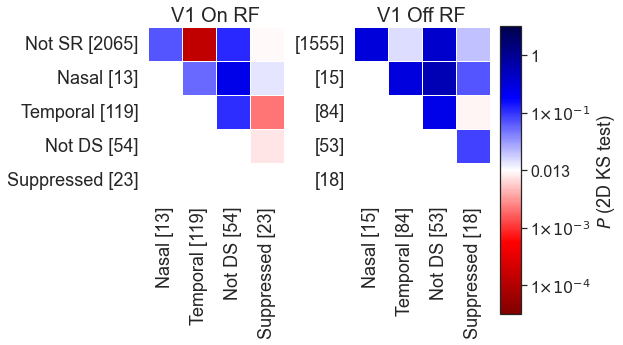

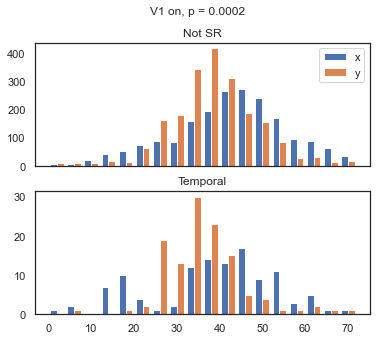

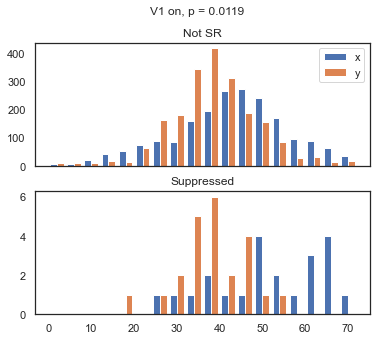

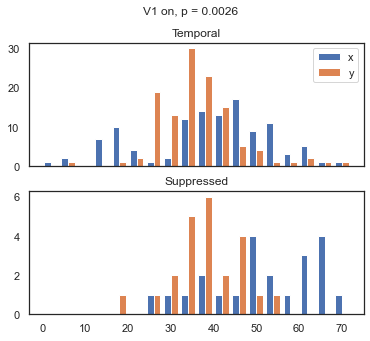

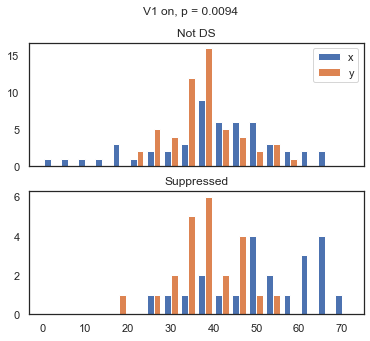

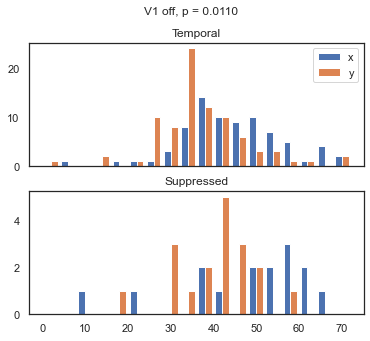

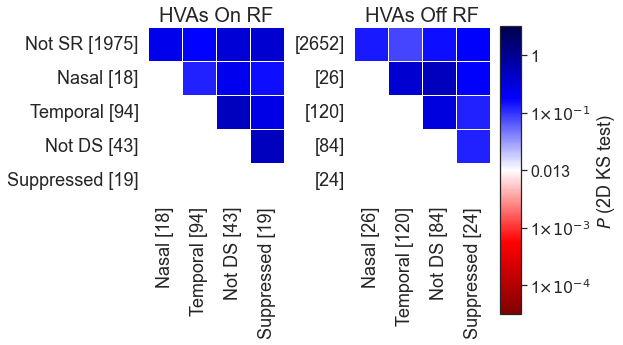

In [27]:
from analysis.ndtest import ks2d2s

for areas, area_name in VISUAL_AREAS:
    fig, axs = plt.subplots(figsize=(7, 5), ncols=2)
    n = len(ids_and_labels_sr_breakdown)

    for col, rf_type in enumerate(("on", "off")):
        xy_cols = [f"rf_center_{rf_type}_x_lsn", f"rf_center_{rf_type}_y_lsn"]
        p_matrix = np.full((n, n-1), np.nan, dtype=float)
        heatmap_labels = np.full_like(p_matrix, "", dtype=object)
        counts = []

        for i in range(n):
            a = cell_metrics[xy_cols][cell_metrics.area.isin(areas) & cell_metrics.cell_specimen_id.isin(ids_and_labels_sr_breakdown[i][0])].dropna().values
            counts.append(len(a))

            for j in range(i+1, n):
                b = cell_metrics[xy_cols][cell_metrics.area.isin(areas) & cell_metrics.cell_specimen_id.isin(ids_and_labels_sr_breakdown[j][0])].dropna().values
                p_val = ks2d2s(x1=a[:,0], y1=a[:,1], x2=b[:,0], y2=b[:,1])
                p_matrix[i,j-1] = p_val
                # p_matrix[j,i] = p_val

                if p_val < 0.05/(n-1):
                    print(area_name, i, j, p_val)
                    fig2, axs2 = plt.subplots(figsize=(6, 5), nrows=2, sharex=True)
                    fig2.suptitle(f"{area_name} {rf_type}, p = {p_val:.4f}")
                    bins = np.arange(0, 75, 4)
                    axs2[0].hist(a, bins=bins, label=["x", "y"])
                    axs2[0].set_title(ids_and_labels_sr_breakdown[i][1])
                    axs2[0].legend()
                    axs2[1].hist(b, bins=bins)
                    axs2[1].set_title(ids_and_labels_sr_breakdown[j][1])

        ax = axs[col]
        if col == 0:
            from mpl_toolkits.axes_grid1.inset_locator import inset_axes
            cbar_ax = inset_axes(ax, width="4%", height="80%", loc="center left", bbox_to_anchor=(1, 0, 1, 1), bbox_transform=fig.transFigure, borderpad=0)
        # ticklabels = [x[1] for x in ids_and_labels_sr_breakdown]
        ticklabels = [f"{x[1]} [{count}]" for x, count in zip(ids_and_labels_sr_breakdown, counts)]
        heatmap_log_proba_plot(p_matrix, xticklabels=ticklabels[1:], yticklabels=ticklabels, title=f"{area_name} {rf_type.capitalize()} RF", titlefontsize=20, ticklabelfontsize=18, ax=ax, is_inset=True, cbar_ax=cbar_ax, cbar_label=f"$P$ (2D KS test)", cbar_label_fontsize=18)

        if col > 0:
            ax.set_yticklabels([f"[{c}]" for c in counts])
    
    fig.tight_layout()
    savefig(fig, f"{SAVE_FOLDER_PREFIX}distribution_tests_2d_{area_name}.png")

# Look at RF area

In [28]:
sr_abbrev = {
    "No response": "Not SR",
    "Suppressed": "Suppr.",
    "Enhanced: No DS": "Not DS",
    "Enhanced: Nasal": "Nasal",
    "Enhanced: Temporal": "Temporal"
}

In [29]:
palette = {sr_abbrev[l]: c for l, c in SR_LABELS}
ordering = [sr_abbrev[l] for l, c in SR_LABELS]

df = []

for rf_type in ("on", "off"):
    rf_area_metric = f"rf_area_{rf_type}_lsn"
    cell_ids_with_rf = cell_metrics.cell_specimen_id.values[~cell_metrics[rf_area_metric].isna()]
    for cell_idx, row in cells[cells.index.isin(cell_ids_with_rf)].iterrows():
        df.append(dict(
            rf_type = rf_type,
            targeted_structure = row["targeted_structure"],
            sr_label = sr_abbrev[row["sr_label"]],
            rf_area = cell_metrics[rf_area_metric][cell_metrics.cell_specimen_id == cell_idx].values[0]
        ))

df = pd.DataFrame(df)
df

,rf_type,targeted_structure,sr_label,rf_area
0,on,VISp,Not SR,123.128840
1,on,VISp,Not SR,500.850931
2,on,VISp,Not SR,32.151151
3,on,VISp,Not SR,69.835222
4,on,VISp,Not SR,11.380531
...,...,...,...,...
9049,off,VISal,Not SR,108.717122
9050,off,VISal,Not SR,641.547085
9051,off,VISal,Not SR,691.617613
9052,off,VISal,Not SR,195.646487


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


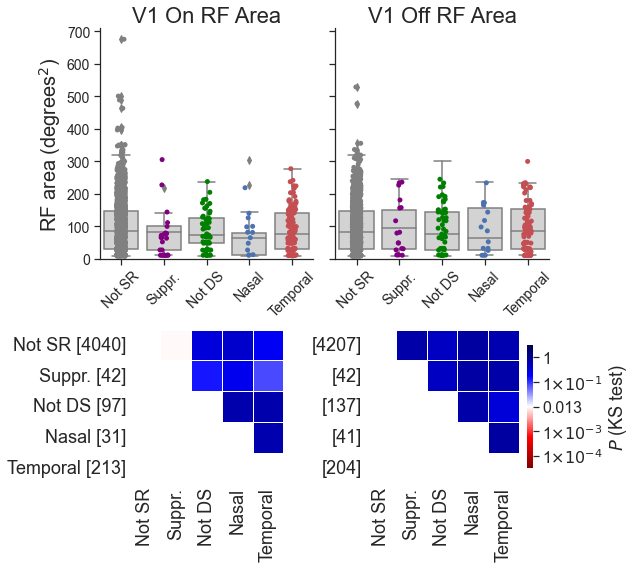

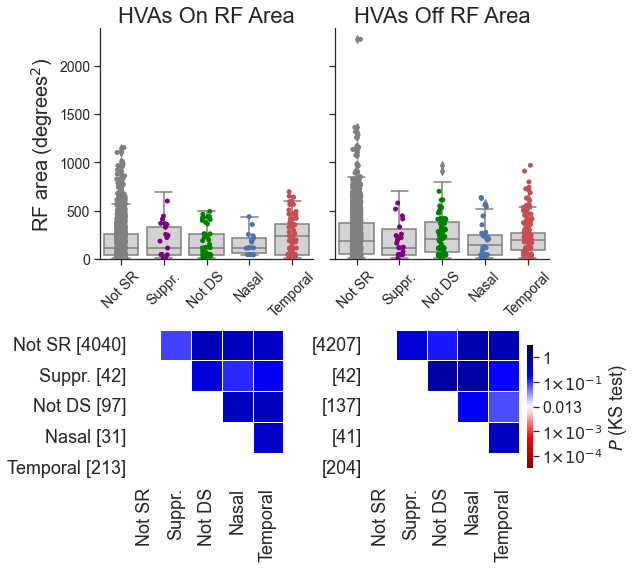

In [35]:
n = len(ordering)
n_onoff = {
    onoff: [np.count_nonzero((df.sr_label == sr_label) & (df.rf_type == onoff)) for sr_label in ordering]
    for onoff in ("on", "off")
}

with sns.axes_style("ticks"):
    for areas, area_name in VISUAL_AREAS:
        fig, axs = plt.subplots(figsize=(8, 8), nrows=2, ncols=2, gridspec_kw={'height_ratios':[1.5,1]})

        for col, rf_type in enumerate(("on", "off")):
            ax = axs[0, col]
            ax_proba = axs[1, col]
            df_sub = df[(df.rf_type == rf_type) & (df.targeted_structure.isin(areas))]

            sns.boxplot(data=df_sub, x="sr_label", y="rf_area", color="lightgray", ax=ax)
            sns.stripplot(data=df_sub, x="sr_label", y="rf_area", palette=palette, order=ordering, ax=ax)
            ax.set_title(f"{area_name} {rf_type.capitalize()} RF Area", fontsize=22)

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            
            plt.setp(ax.get_xticklabels(), fontsize=14, rotation=45)
            plt.setp(ax.get_yticklabels(), fontsize=14)
            ax.set_xlabel("")
            ax.set_ylabel("RF area (degrees$^2$)" if col == 0 else "", fontsize=20)
            if col > 0:
                ax.set_yticklabels([])

            p_matrix = np.full((n, n), np.nan, dtype=float)

            for i in range(n):
                a = df_sub["rf_area"][df_sub.sr_label == ordering[i]].dropna().values
                counts.append(len(a))

                for j in range(i+1, n):
                    b = df_sub["rf_area"][df_sub.sr_label == ordering[j]].dropna().values
                    _, p_val = scipy.stats.kstest(a, b)
                    p_matrix[i,j] = p_val
            #         # p_matrix[j,i] = p_val

            #         if p_val < 0.05/(n-1):
            #             print(area_name, i, j, p_val)
            #             fig2, axs2 = plt.subplots(figsize=(6, 5), nrows=2, sharex=True)
            #             fig2.suptitle(f"{area_name} {rf_type}, p = {p_val:.4f}")
            #             bins = np.arange(0, 75, 4)
            #             axs2[0].hist(a, bins=bins, label=["x", "y"])
            #             axs2[0].set_title(ids_and_labels_sr_breakdown[i][1])
            #             axs2[0].legend()
            #             axs2[1].hist(b, bins=bins)
            #             axs2[1].set_title(ids_and_labels_sr_breakdown[j][1])

            # if col == 0:
            #     from mpl_toolkits.axes_grid1.inset_locator import inset_axes
            #     cbar_ax = inset_axes(ax, width="4%", height="80%", loc="center left", bbox_to_anchor=(1, 0, 1, 1), bbox_transform=fig.transFigure, borderpad=0)
            # # ticklabels = [x[1] for x in ids_and_labels_sr_breakdown]
            # ticklabels = [f"{x[1]} [{count}]" for x, count in zip(ids_and_labels_sr_breakdown, counts)]
            show_cbar = col > 0
            cbar_ax = inset_axes(ax_proba, width="4%", height="80%", loc="center left", bbox_to_anchor=(1.05, 0, 1, 1), bbox_transform=ax_proba.transAxes, borderpad=0) if show_cbar else None
            xticklabels = ordering
            if col == 0:
                yticklabels = [f"{label} [{n_of_type}]" for label, n_of_type in zip(ordering, n_onoff[rf_type])]
            else:
                yticklabels = [f"[{n_of_type}]" for n_of_type in n_onoff[rf_type]]

            heatmap_log_proba_plot(
                p_matrix, xticklabels=xticklabels, yticklabels=yticklabels, title="", titlefontsize=20, ticklabelfontsize=18, ax=ax_proba,
                cbar_ax=cbar_ax, show_cbar=show_cbar,
                cbar_label=f"$P$ (KS test)", cbar_label_fontsize=18
            )
            ax_proba.tick_params(length=0)
            
            # ax_pmatrix = inset_axes(ax, width=3, height=2.5, loc="upper right")
            # heatmap_log_proba_plot(
            #     p_matrix, ticklabels=ordering, title="", titlefontsize=20, ticklabelfontsize=18, ax=ax_pmatrix,
            #     cbar_label=f"$P$ (KS test)", cbar_label_fontsize=18
            # )
            
            # heatmap_log_proba_plot(
            #     p_matrix, xticklabels=ticklabels[1:], yticklabels=ticklabels, title=f"{area_name} {rf_type.capitalize()} RF", titlefontsize=20, ticklabelfontsize=18, ax=ax,
            #     is_inset=True, cbar_ax=cbar_ax, cbar_label=f"$P$ (2D KS test)", cbar_label_fontsize=18
            # )

            # if col > 0:
            #     ax.set_yticklabels([f"[{c}]" for c in counts])
        
        # RF area plots have same y ticks
        ylim = (0, max(ax.get_ylim()[1] for ax in axs[0]))
        for ax in axs[0]:
            ax.set_ylim(ylim)
        
        fig.tight_layout()
        savefig(fig, f"{SAVE_FOLDER_PREFIX}rf_area_{area_name}.png")